# Exploration of sensitivity of a modified SEIR model

Peter Vanya, 17/04/20

### Intro

A simple SEIR model for a whole population 
with no spatial/regional resolution is implemented.

Here, the SEIR equations are modified compared with the standard 
literature to better account for the behaviour of COVID.
The interaction term $\beta SE$ is used instead of $\beta SI$,
meaning that the "exposed" individuals are infected without
knowing so and are freely spreading the disease until the
symptoms reveal the infection after the incubation period.
At that point, they turn into "infected" and transfer to group
$I$ and do not spread the disease anymore, as they are 
quarantined at home or at hospitals.

This is effectively a quarantined model 
(Osemwinyen, 2015, 10.11648/j.acm.20150404.19).

A free parameter $f<1$ is added to denote a fraction of individuals
that develop symptoms after the incubation period and move into $I$ group.

Furthermore, a recovery term for $E$ group with rate $\gamma_2$ 
is added to account for the fact that some exposed individuals 
recover without any action or without their noticing.

The modified equations are as follows:

\begin{align}
\dot S(t) &= -\beta SE,\\
\dot E(t) &= \beta SE - f a E - \gamma_2 E,\\
\dot I(t) &= f a E - \gamma_1 I,\\
\dot R(t) &= \gamma_1 I + \gamma_2 E.
\end{align}

where $S,E,I,R$ are fractions of the population.
Among the parameters, $\beta$ is the infection rate, 
$\gamma_i$ the recovery rates and $1/a$ the incubation period.

The basic reproduction number is the ratio of $\beta$ and some combination
of $\gamma_i$; the exact form is not derived here. In the simulations
below, $\gamma_i$ will be the same for simplicity and only $\beta$
will be manipulated.

A simple Euler integrator is used.

### Problem statement

After an initial period of free spread, the reproduction number 
$R_t$ is changed to a new, lower value, indicating the quarantine.

Here, the effect of different  values on the the epidemy peak 
is modelled. Furthermore, the effect of the incubation period
is investigated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. SEIR with constant reproduction rate $R_t$

Setting the parameters:
* the conversion rate of symptoms $f=0.5$,
* $a=0.16$ to represent the incubation period of about 6 days (http://gabgoh.github.io/COVID/index.html),,
* $\gamma_{1/2}=0.1$ denoting the recovery time of about 10 days,
* use the same recovery rate $\gamma$ for both exposed and infected groups,
* $\beta=0.4$ to use the free spreading rate $R_t=4$.

In [2]:
def simulate_seir(beta, gamma_1, gamma_2, a, S0, E0, I0, R0, \
                  dt, N_step, f):
    S = S0 * np.ones(N_step)
    E = E0 * np.ones(N_step)
    I = I0 * np.ones(N_step)
    R = R0 * np.ones(N_step)
    
    for i in range(0, N_step-1):
        dSdt = -beta*S[i]*E[i]
        dEdt = beta*S[i]*E[i] - f*a*E[i] - gamma_2*E[i]
        dIdt = f*a*E[i] - gamma_1*I[i]
        dRdt = gamma_1*I[i] + gamma_2*E[i]

        S[i+1] = S[i] + dSdt*dt
        E[i+1] = E[i] + dEdt*dt
        I[i+1] = I[i] + dIdt*dt
        R[i+1] = R[i] + dRdt*dt
        
    return S, E, I, R

In [3]:
# simulation parameters
T = 200.0   # simulation period
dt = 1e-1   # integration timestep
N_step = int(T/dt)
t = np.arange(0, N_step*dt, dt)

gamma = 0.1    # recovery rate
beta = 0.4     # infection rate, from typical R0 = 4 for COVID
a = 0.16       # inverse incubation period of 6 days
f = 0.5

In [4]:
# initial conditions
I0 = 1e-10 # effectively zero
E0 = 1e-5  # order of 100 people for a country of 10M citizens
S0 = 1.0 - I0 - E0
R0 = 0.0

In [5]:
S, E, I, R = simulate_seir(beta, gamma, gamma, a, S0, E0, I0, R0, dt, N_step, f)

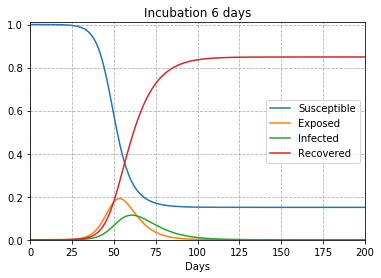

In [6]:
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.grid(ls="--")
plt.xlim([t[0], t[-1]])
plt.ylim([0, 1.01])
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylabel("")
plt.title("Incubation %i days" % (1/a));

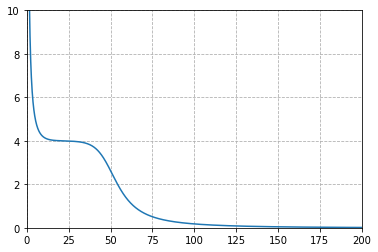

In [7]:
# ratio of exposed/infected
plt.plot(t, E/I)
plt.xlim([t[0], t[-1]])
plt.ylim([0, 10])
plt.grid(ls="--");

**Comment:** After the initial excess of exposed people with no symptoms, 
for conversion ratio $f=0.5$ there is for several weeks 
about 4x more exposed than confirmed infected individuals.
Hence, there are about 5x more infected people than can be revealed by
testing of heavy symptoms only in hospitals.

## 2. Varying the incubation period $1/a$

Observe the effect of different incubation periods on the evolution of the epidemic.

In [8]:
As = [1.0 / ti for ti in [1, 2, 4, 6, 10, 20]]
beta = 0.4
gamma = 0.1

T = 200.0
dt = 1.0
N_step = int(T/dt)
t = np.arange(0, N_step*dt, dt)

S, E, I, R = {}, {}, {}, {}

for i, a in enumerate(As):
    I0 = 1e-10
    E0 = 1e-5
    S0 = 1.0 - I0 - E0
    R0 = 0.0
    S[a], E[a], I[a], R[a] = \
        simulate_seir(beta, gamma, gamma, a, S0, E0, I0, R0, dt, N_step, f)

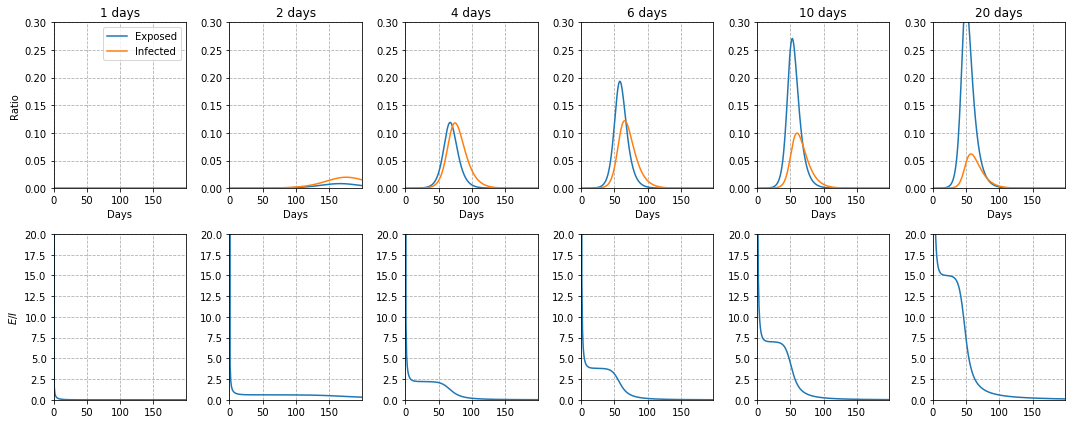

In [9]:
fig, ax  = plt.subplots(2, len(As), figsize=[15, 6])

for i, a in enumerate(As):
    ax[0, i].plot(t, E[a], label="Exposed")
    ax[0, i].plot(t, I[a], label="Infected")
    ax[0, i].set_xlabel("Days")
    ax[0, i].set_title("%i days" % (1/a))
    ax[0, i].grid(ls="--")
    ax[0, i].set_ylim([0, 0.3])
    ax[0, i].set_xlim([t[0], t[-1]])
    
    ax[1, i].plot(t, E[a]/I[a])
    ax[1, i].grid(ls="--")
    ax[1, i].set_ylim([0, 20])
    ax[1, i].set_xlim([t[0], t[-1]])
    

ax[0, 0].set_ylabel("Ratio")
ax[1, 0].set_ylabel("$E/I$")    
ax[0, 0].legend()
plt.tight_layout()

**Comment:** As expected, incubation period has a significant influence on the peak size.
The longer it takes, the longer the time exposed group can spread out the epidemic
without knowledge.

The ratios between the known infected (I) and exposed and infected (E) gets to 4-7 
for 6-10 days incubation period.

## 3. Lowering $R_t$ after first few days

Starting with several exposed individuals, lower $\beta$ after first 10 days
to capture the quarantine measures for everyone.

In [10]:
def simulate_seir_cut(betas, gamma, gamma_2, a, \
                      S0, E0, I0, R0, dt, N_step, f):
    """betas: a vector with the size of the number of timesteps"""
    S = S0 * np.ones(N_step)
    E = E0 * np.ones(N_step)
    I = I0 * np.ones(N_step)
    R = R0 * np.ones(N_step)
    
    for i in range(0, N_step-1):
        dSdt = -betas[i]*S[i]*E[i]
        dEdt = betas[i]*S[i]*E[i] - f*a*E[i] - gamma_2*E[i]
        dIdt = f*a*E[i] - gamma*I[i]
        dRdt = gamma*I[i] + gamma_2*E[i]

        S[i+1] = S[i] + dSdt*dt
        E[i+1] = E[i] + dEdt*dt
        I[i+1] = I[i] + dIdt*dt
        R[i+1] = R[i] + dRdt*dt
        
    return S, E, I, R

In [18]:
# simulation parameters
T = 300.0
dt = 5e-1
N_step = int(T/dt)
t = np.arange(0, N_step*dt, dt)
N_pop = 5e6

gamma = 0.1
a = 0.16
f = 0.5

T_cut = 10.0 # cut it after this many days
N_cut = int(T_cut/T*N_step)

beta0 = 0.4
beta_cut = 0.14
betas = beta0 * np.ones(N_step)
betas[N_cut:] = beta_cut

# initial conditions
I0 = 1e-10
E0 = 1e-5
S0 = 1.0 - E0 - I0
R0 = 0.0

In [19]:
S, E, I, R = simulate_seir_cut(betas, gamma, gamma, a, S0, E0, I0, R0, dt, N_step, f)

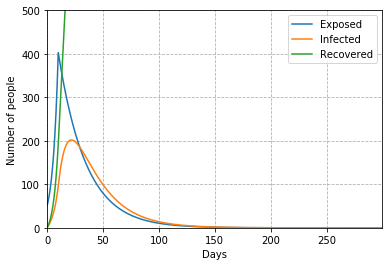

In [21]:
#plt.plot(t, S*N_pop, label="Susceptible")
plt.plot(t, E*N_pop, label="Exposed")
plt.plot(t, I*N_pop, label="Infected")
plt.plot(t, R*N_pop, label="Recovered")
plt.grid(ls="--")
plt.xlim([t[0], t[-1]])
plt.ylim([0.1, 0.5e3])
plt.xlabel("Days")
plt.ylabel("Number of people")
plt.legend();

**Comment:** The exposed drop immediately, the infected more smoothly. 
The recovered rise up significantly compared with $E$ and $I$.

### Several values of $\beta$ after quarantine

* Starting from 50 exposed people in a population of 5M (Slovakia).
* Setting out 20 days a time to recognise the outbreak of the epidemic and enforce quarantine

In [28]:
betas_q = [0.21, 0.2, 0.19, 0.15, 0.14, 0.12]
beta0 = 0.4
gamma = 0.1
a = 0.16
f = 0.5

T = 400.0
dt = 1.0
N_step = int(T/dt)
t = np.arange(0, N_step*dt, dt)

T_cut = 20.0    # quarantine after this many days
N_cut = int(T_cut/T*N_step)
N_pop = 5e6

In [29]:
S, E, I, R = {}, {}, {}, {}

for i, bq in enumerate(betas_q):
    betas = beta0 * np.ones(N_step)
    betas[N_cut:] = bq
    
    E0 = 1e-5
    I0 = 1e-10
    S0 = 1.0 - E0 - I0
    R0 = 0.0
    
    S[bq], E[bq], I[bq], R[bq] = \
        simulate_seir_cut(betas, gamma, gamma, a, S0, E0, I0, R0, dt, N_step, f)

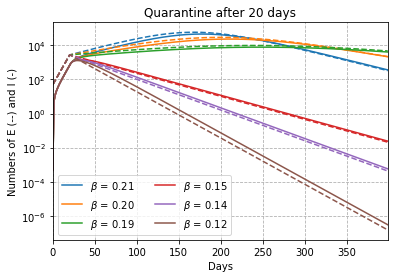

In [40]:
fig, ax = plt.subplots()

for i, bq in enumerate(betas_q):
    plt.plot(t, I[bq]*N_pop, label="$\\beta$ = %.2f" % bq)
    plt.plot(t, E[bq]*N_pop, "--", color="C%i" % i)

plt.legend(ncol=2, loc="best")
plt.xlabel("Days")
plt.ylabel("Numbers of E (--) and I (-)")
plt.title("Quarantine after %i days" % T_cut)
plt.grid(ls="--", which="major")
#plt.ylim([0, 2e4])
plt.yscale("log")
plt.xlim([t[0], t[-1]]);

**Comments:** The resulting decay is extremely sensitive to the value $\beta$
under quarantine measures for all. For $\beta$ around 2.0 the epidemic keeps
spreading. For $\beta<0.15$, it is over after 50-100 days.

A closer look:

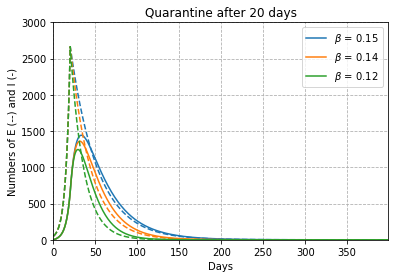

In [41]:
fig, ax = plt.subplots()

for i, bq in enumerate(betas_q[-3:]):
    plt.plot(t, I[bq]*N_pop, label="$\\beta$ = %.2f" % bq)
    plt.plot(t, E[bq]*N_pop, "--", color="C%i" % i)

plt.legend()
plt.xlabel("Days")
plt.ylabel("Numbers of E (--) and I (-)")
plt.title("Quarantine after %i days" % T_cut)
plt.grid(ls="--", which="major")
plt.ylim([0, 3e3])
plt.xlim([t[0], t[-1]]);